# $C$$O_2$ Mauna Loa Gaussian Process Regression

The goal of this notebook is to replicate the results from [chapter 5](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf), p.118, of [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/chapters/).

The hint (see [here](https://github.com/GPflow/GPflow/issues/491)) on how to predicting component contributions with [GPflow](https://github.com/GPflow/GPflow) came from [Dan Marthaler](https://github.com/mathDR).

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, GPflow

In [2]:
# The data used to be available at http://cdiac.esd.ornl.gov/ftp/trends/co2/maunaloa.co2, 
# but now it seems that more up-to-date data can be found at 
# ftp://ftp.cmdl.noaa.gov/ccg/co2/trends/co2_mm_mlo.txt

import statsmodels.api as sm

data1 = sm.datasets.get_rdataset("co2").data
data1.head()

,time,co2
0,1959.000000,315.42
1,1959.083333,316.31
2,1959.166667,316.50
3,1959.250000,317.56
4,1959.333333,318.13


In [3]:
x = np.array(data1.time)
y = np.array(data1.co2)
X = x.reshape(-1, 1)
Y = y.reshape(-1, 1)

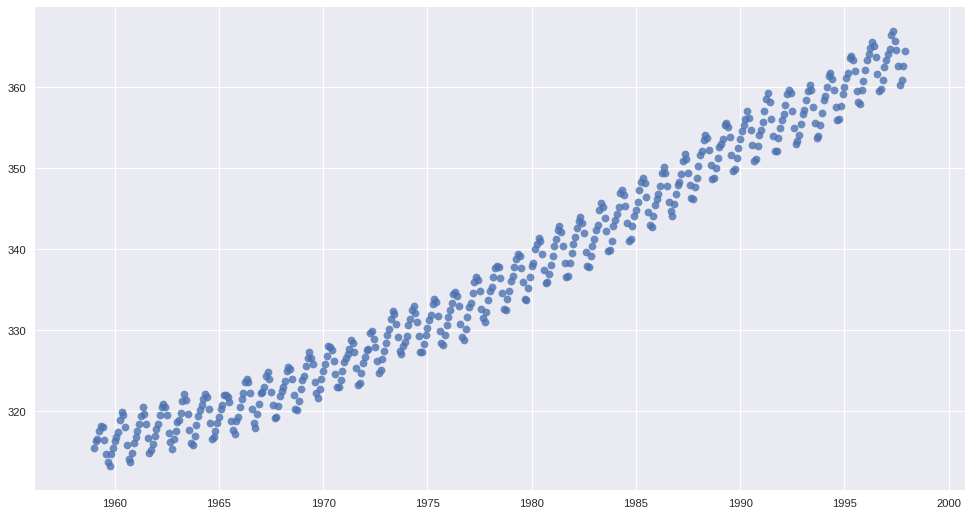

In [4]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
sns.regplot(x, y, fit_reg=False)

In [5]:
k1 = GPflow.kernels.RBF(1, variance=(66.0 ** 2), lengthscales=67.0)
k2_exp_sine_squred_gamma= 2.0 / 1.3 ** 2
k2_exp_sine_squred_period = 1.0
k2 = GPflow.kernels.RBF(1, variance=(2.4 ** 2), lengthscales=90) * GPflow.kernels.PeriodicKernel(1, period=k2_exp_sine_squred_period, variance=1.0, lengthscales=1/k2_exp_sine_squred_gamma)
# k3 = how to do a rational quadratic term in GPflow?
k4 = GPflow.kernels.RBF(1, variance=(0.18 ** 2), lengthscales=1.6) + GPflow.kernels.White(1, variance=0.19)

kernel = k1 + k2 + k4

m = GPflow.gpr.GPR(X, Y, kern=kernel)
m.likelihood.variance = 0.01
m

Name,values,prior,constraint
name.kern.prod.periodickernel.lengthscales,[ 0.845],None,+ve
name.kern.prod.periodickernel.period,[ 1.],None,+ve
name.kern.prod.periodickernel.variance,[ 1.],None,+ve
name.kern.prod.rbf.lengthscales,[ 90.],None,+ve
name.kern.prod.rbf.variance,[ 5.76],None,+ve
name.kern.rbf_1.lengthscales,[ 67.],None,+ve
name.kern.rbf_1.variance,[ 4356.],None,+ve
name.kern.rbf_2.lengthscales,[ 1.6],None,+ve
name.kern.rbf_2.variance,[ 0.0324],None,+ve
name.kern.white.variance,[ 0.19],None,+ve


In [6]:
%%time
m.optimize()

CPU times: user 49.8 s, sys: 5.67 s, total: 55.4 s
Wall time: 11.5 s


      fun: 129.03234853639407
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.03641972,  0.16268957, -0.00595096, -0.04949717, -0.00168133,
       -0.00410956, -0.0048979 , -0.0083654 , -0.01864009, -0.05637233,
       -0.01805678])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 225
      nit: 157
   status: 0
  success: True
        x: array([ -4.43667059e-02,   5.40852692e-01,   5.82720451e-01,
         9.18896168e+01,   5.63757395e+00,   4.85940092e+01,
         4.35621927e+03,  -9.48604462e-01,  -1.74924228e+00,
        -3.42579060e+00,  -4.58611302e+00])

In [7]:
m

Name,values,prior,constraint
name.kern.prod.periodickernel.lengthscales,[ 0.67121086],None,+ve
name.kern.prod.periodickernel.period,[ 0.99970256],None,+ve
name.kern.prod.periodickernel.variance,[ 1.02636651],None,+ve
name.kern.prod.rbf.lengthscales,[ 91.88961784],None,+ve
name.kern.prod.rbf.variance,[ 5.64113012],None,+ve
name.kern.rbf_1.lengthscales,[ 48.59401021],None,+ve
name.kern.rbf_1.variance,[ 4356.21926937],None,+ve
name.kern.rbf_2.lengthscales,[ 0.3273468],None,+ve
name.kern.rbf_2.variance,[ 0.16033736],None,+ve
name.kern.white.variance,[ 0.03200686],None,+ve


In [8]:
def plot(m, with_data=True):
    if not isinstance(m, list):
        m = [m]
    predictions = [model.predict_y(xx) for model in m]
    if with_data:
        plt.plot(X, Y, 'kx', mew=2)
    for mean, var in predictions:
        line, = plt.plot(xx, mean, lw=2)
        plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2)

As you can see in the below figure the complete model matches nicely.

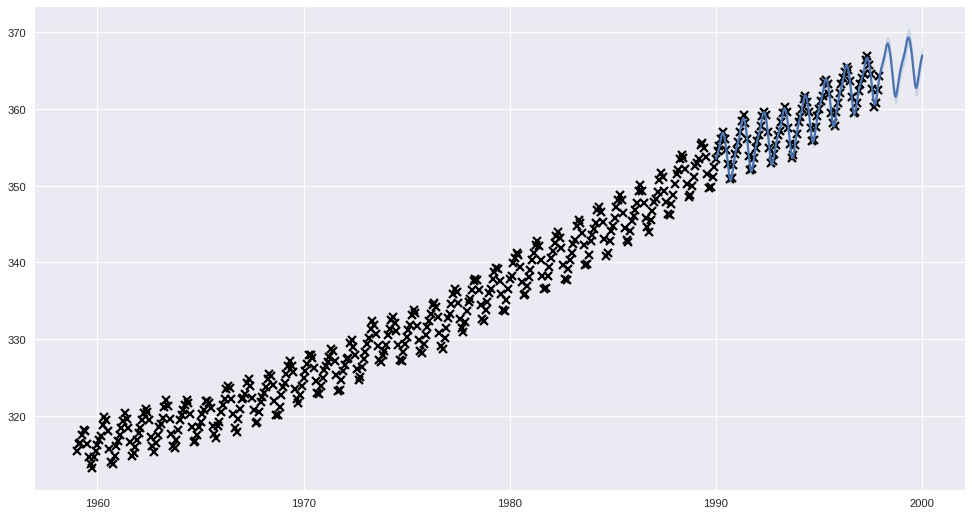

In [9]:
xx = np.linspace(1990, 2000, 1000).reshape(-1,1)
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
plot(m)

Now let's split the model into components and create model $m_1$ (blue) with only the long term trend and model $m_2$ (green) with only the product term of [p.120](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf):
$$
\begin{eqnarray}
k_2(x,x')&=&\theta_3^2\cdot\hbox{exp}\left(-\frac{(x-x')^2}{2\theta_4^2}-\frac{2\sin^2(\pi(x-x')/1.0)}{\theta_5^2}\right)\\
&=&\left(\theta_3^2\cdot\hbox{exp}\left(-\frac{(x-x')^2}{2\theta_4^2}\right)\right)\cdot\left(1.0\cdot\hbox{exp}\left(-\frac{2\sin^2(\pi(x-x')/1.0)}{\theta_5^2}\right)\right)
\end{eqnarray}
$$

Where $\theta_3$ is the `variance` term in the `RBF` kernel and therefore the `variance` term in the `PeriodicKernel` kernel will be $1.0$.

In [10]:
k1 = GPflow.kernels.RBF(1, variance=m.kern.rbf_1.variance.value, lengthscales=m.kern.rbf_1.lengthscales.value)
m1 = GPflow.gpr.GPR(X, Y, kern=k1)
m1.likelihood.variance = m.likelihood.variance.value
m1.fixed = True

k2 = GPflow.kernels.RBF(1, variance=m.kern.prod.rbf.variance.value, lengthscales=m.kern.prod.rbf.lengthscales.value) \
    * \
    GPflow.kernels.PeriodicKernel(1, period=m.kern.prod.periodickernel.period.value, 
                                  variance=m.kern.prod.periodickernel.variance.value, 
                                  lengthscales=m.kern.prod.periodickernel.lengthscales.value)
m2 = GPflow.gpr.GPR(X, Y, kern=k2)
m2.likelihood.variance = m.likelihood.variance.value
m2.fixed = True

k1 = GPflow.kernels.RBF(1, variance=m.kern.rbf_1.variance.value, lengthscales=m.kern.rbf_1.lengthscales.value)
k2 = GPflow.kernels.RBF(1, variance=m.kern.prod.rbf.variance.value, lengthscales=m.kern.prod.rbf.lengthscales.value) \
    * \
    GPflow.kernels.PeriodicKernel(1, period=m.kern.prod.periodickernel.period.value, 
                                  variance=m.kern.prod.periodickernel.variance.value, 
                                  lengthscales=m.kern.prod.periodickernel.lengthscales.value)
m3 = GPflow.gpr.GPR(X, Y, kern=(k1+k2))
m3.likelihood.variance = m.likelihood.variance.value
m3.fixed = True

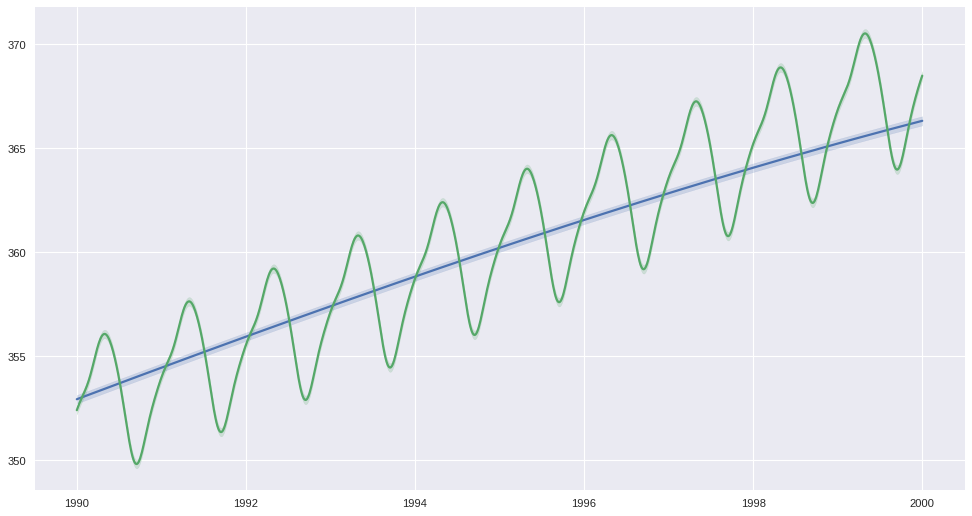

In [11]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
plot([m1, m2], with_data=False)

And if we then plot $m_1$ (blue) and $m_2$ (green) and the combined/full model $m_3$ (red) in the same graph we get the picture below.

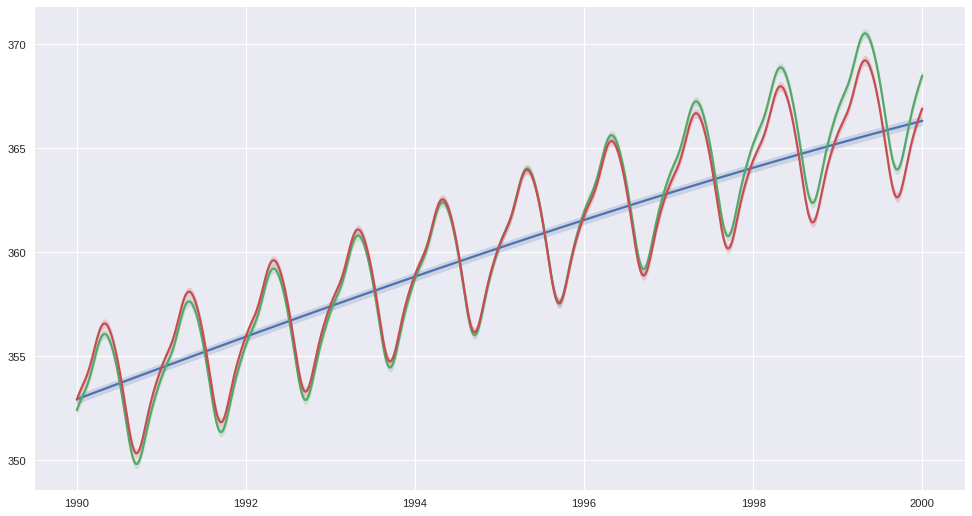

In [12]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
plot([m1, m2, m3], with_data=False)

Now this is confusing me. Most likely this will be due to a general misunderstanding on my part. But I was thinking that the green line would be added ontop of the blue line and therefore the red line cannot be more or less the same as the green line??

In addition, how do I then get the [Figure 5.7 (b)](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf) and also for the different years as shown for 1958, 1970 and 2003 (besides the fact that my data from above does not go that far).

It turns out that the simplistic idea on how to decompose the additive components of the model is not correct, but more involved.

Have a look at [The Kernel Cookbook](http://www.cs.toronto.edu/~duvenaud/cookbook/index.html) and scroll down to "Additive decomposition" or look at equation 1.17 at the [kernels](https://github.com/duvenaud/phd-thesis/blob/master/kernels.pdf) chapter of David Duvenaud's Phd [thesis](https://github.com/duvenaud/phd-thesis/).

There it says (I leave out the $\mu$ variables as we set the mean function to be 0):
$$ f_1(X^*)|f_1(X) + f_2(X) \sim \mathcal{N}\left({K_1^*}^T(K_1+K_2)^{-1}[f_1(X) + f_2(X)], ...\right)$$
but our simplistic approach from above would have calculated the following:
$$ f_1(X^*)|f_1(X) + f_2(X) \sim \mathcal{N}\left({K_1^*}^TK_1^{-1}[f_1(X) + f_2(X)], ...\right)$$

I did not find a way on how to make GPflow perform this additive decomposition and therefore I decided to implement it by hand. In this set-up GPflow is used to find the correct parameters and the hand writte code is used to decompose the addtitive parts.

In [13]:
import functools

# http://www.cs.toronto.edu/~duvenaud/cookbook/index.html

class GPCovarianceFunctionWhiteNoise:
    def __init__(self, sigma):
        self.sigma = float(sigma)

    def covariance(self, x1, x2):
        lr = np.zeros(shape=(len(x1), len(x2)))
        np.fill_diagonal(lr, self.sigma ** 2)
        return lr

class GPCovarianceFunctionSquaredExponential:
    def __init__(self, l, sigma):
        self.l = float(l)
        self.sigma = float(sigma)

    def covariance(self, x1, x2):
        return (self.sigma**2) * np.exp( -0.5 * (np.subtract.outer(x1, x2)**2) / (self.l ** 2))

class GPCovarianceFunctionExpSine2Kernel:
    def __init__(self, l, period, sigma):
        self.l = float(l)
        self.period = float(period)
        self.sigma = float(sigma)

    def covariance(self, x1, x2):
        return (self.sigma**2) * np.exp( -2.0 * np.power(np.sin((np.pi / self.period) * np.abs(np.subtract.outer(x1, x2))),
                                                         2) / (self.l ** 2))

class GPCovarianceFunctionSum:
    def __init__(self, k1, k2):
        self.k1 = k1
        self.k2 = k2

    def covariance(self, x1, x2):
        s1 = self.k1.covariance(x1, x2)
        s2 = self.k2.covariance(x1, x2)
        s = s1 + s2
        return  s

class GPCovarianceFunctionProduct:
    def __init__(self, k1, k2):
        self.k1 = k1
        self.k2 = k2

    def covariance(self, x1, x2):
        p1 = self.k1.covariance(x1, x2)
        p2 = self.k2.covariance(x1, x2)
        p = p1 * p2
        return  p

def conditional(x_new, x, y, cov, sigma_n=0):
    if not isinstance(cov, list):
        cov = [cov]

    if len(cov) < 2:
        total_covariance_function = cov[0]
    else:
        total_covariance_function = functools.reduce(lambda a, x: GPCovarianceFunctionSum(a, x), cov)

    A = total_covariance_function.covariance(x_new, x_new)
    C = total_covariance_function.covariance(x_new, x)
    B = total_covariance_function.covariance(x, x) + np.power(sigma_n,2)*np.diag(np.ones(len(x)))

    mu = [np.linalg.inv(B).dot(C.T).T.dot(y).squeeze()]
    sigma = [A - C.dot(np.linalg.inv(B).dot(C.T)).squeeze()]

    for i in range(0, len(cov)):
        partial_covariance_function = cov[i]
        C_ = partial_covariance_function.covariance(x_new, x)
        mu_ = np.linalg.inv(B).dot(C_.T).T.dot(y).squeeze()
        mu.append(mu_)

    return (mu, sigma)

def predict(x_new, x, y, cov, sigma_n=0):
    l_y_pred, l_sigmas = conditional(x_new, x, y, cov=cov, sigma_n=sigma_n)
    if len(l_sigmas[0].shape) > 1:
        return l_y_pred, [np.diagonal(ls) for ls in l_sigmas]
    else:
        return l_y_pred, l_sigmas

In [14]:
xx = np.linspace(1990, 2000, 1000)
k1 = GPCovarianceFunctionSquaredExponential(l=48.59401021, sigma=np.sqrt(4356.21926937))
k2 = GPCovarianceFunctionProduct(GPCovarianceFunctionSquaredExponential(l=91.88961784, sigma=np.sqrt(5.64113012)),
                                 GPCovarianceFunctionExpSine2Kernel(l=0.67121086, period=0.99970256, 
                                                                    sigma=1.02636651))

k4 = GPCovarianceFunctionSum(GPCovarianceFunctionSquaredExponential(l=0.3273468, sigma=np.sqrt(0.16033736)),
                             GPCovarianceFunctionWhiteNoise(sigma=np.sqrt(0.03200686)))

k = GPCovarianceFunctionSum(k1, GPCovarianceFunctionSum(k2, k4))

# y_pred, sigmas = gp_basics.predict(xx, x, y, cov=k, sigma_n=np.sqrt(0.01014181))
y_pred, sigmas = predict(xx, x, y, cov=[k1, k2, k4], sigma_n=np.sqrt(0.01014181))

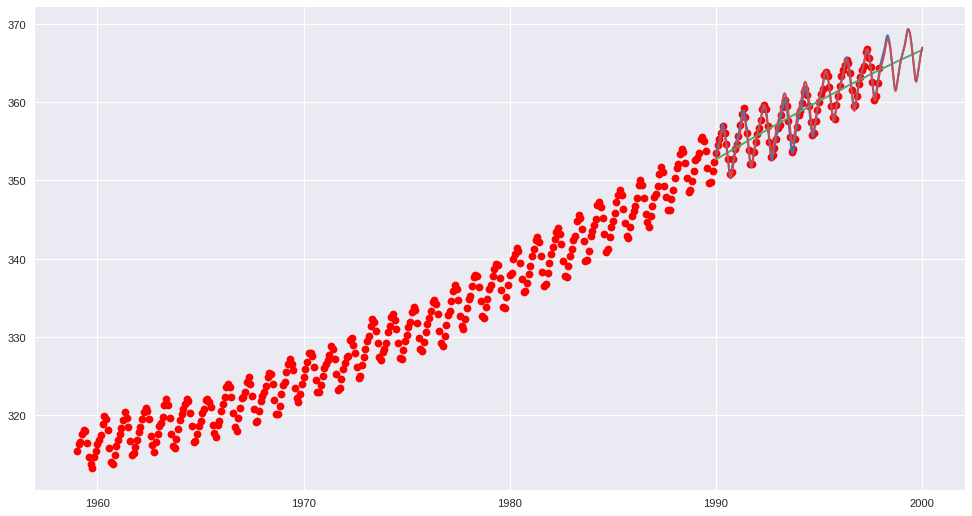

In [15]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
# ax.errorbar(xpts, y_pred, yerr=sigmas, capsize=0)
ax.plot(x, y, "ro")
line1, = ax.plot(xx, y_pred[0])
line2, = ax.plot(xx, y_pred[1])
line3, = ax.plot(xx, y_pred[1] + y_pred[2])

Let's use the [bokeh](https://bokeh.pydata.org/en/latest/) library to make the chart interactive and so that you can zoom in. The hints on how to use bokeh on these examples came from [Looking at the Keeling Curve with GPs in PyMC3](https://bwengals.github.io/looking-at-the-keeling-curve-with-gps-in-pymc3.html).

In [16]:
import bokeh.plotting, bokeh.models, bokeh.io, bokeh.palettes

In [17]:
bokeh.io.output_notebook()

Loading BokehJS ...

In [18]:
p = bokeh.plotting.figure(title="Fit to the Mauna Loa Data", x_axis_type='datetime', 
                          plot_width=900, plot_height=600)
p.yaxis.axis_label = 'CO2 [ppm]'
p.xaxis.axis_label = 'Date'

# total fit
p.line(xx, y_pred[0],  line_width=1, line_color="firebrick", legend="Total fit")

# trend
p.line(xx, y_pred[1], line_width=1, line_color="blue", legend="Long term trend")

# trend + seasonal variation
p.line(xx, y_pred[1] + y_pred[2], line_width=1, line_color="green", legend="Long term trend + seasonal variation")

# true value
p.circle(x, y, color="black", legend="Observed data")
p.legend.location = "top_left"
bokeh.plotting.show(p)

If we then want to look at the seasonal variation (k2) and the short term variation (k4) we can do that as follows and we see that we get the expected result:

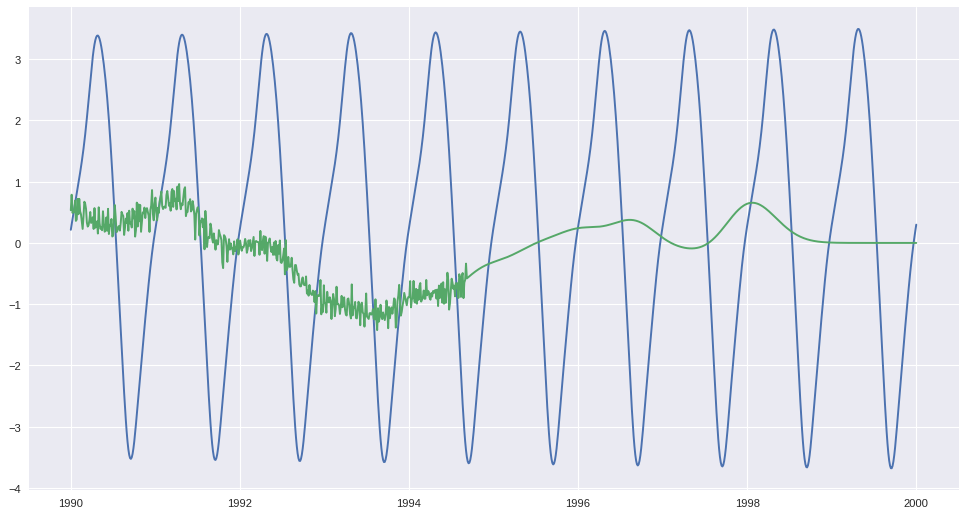

In [19]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
line2, = ax.plot(xx, y_pred[2])
line4, = ax.plot(xx, y_pred[3])

Again, let's use bokeh to make the chart zoomable and interactive:

In [20]:
# plot several years

def dates_to_idx(timelist):
    reference_time = pd.to_datetime('1959-01-01')
    t = (timelist - reference_time) / pd.Timedelta(1, "Y")
    return np.asarray(t)+1959

p = bokeh.plotting.figure(title="Several years of the seasonal component",
           plot_width=900, plot_height=600)
p.yaxis.axis_label = 'Δ CO2 [ppm]'
p.xaxis.axis_label = 'Month'

colors = bokeh.palettes.brewer['Paired'][5]
years = ["1960", "1970", "1980", "1990", "2000"]


In [21]:
# xx = np.linspace(1990, 2000, 1000)
# 
for i, year in enumerate(years):
    dates = pd.date_range(start="1/1/"+year, end="12/31/"+year, freq="10D")
    tnew = dates_to_idx(dates)

    print("Predicting year", year)
    y_pred, sigmas = predict(tnew, x, y, cov=[k1, k2, k4], sigma_n=np.sqrt(0.01014181))

    # plot mean
    t = np.asarray((dates - dates[0])/pd.Timedelta(1, "M")) + 1
    p.line(t, y_pred[2], line_width=1, line_color=colors[i], legend=year)

p.legend.location = "bottom_left"
bokeh.plotting.show(p)

Predicting year 1960
Predicting year 1970
Predicting year 1980
Predicting year 1990
Predicting year 2000
